In [1]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

from data import load_train_data, load_test_data

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 96
img_cols = 96

smooth = 1.


def load_train_data():
    imgs_train = np.load('numpy_data/imgs_train_resized.npy')
    imgs_mask = np.load('numpy_data/imgs_mask_train_resized.npy')
    imgs_mask1 = np.load('numpy_data/imgs_mask1_train_resized.npy')
    # imgs_train = np.load('imgs_train.npy')
    # imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask, imgs_mask1


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


"""
- loss: -0.0526 - conv2d_20_loss: -0.0289 - conv2d_24_loss: -0.0237 - 
- conv2d_20_dice_coef: 0.0289 - conv2d_24_dice_coef: 0.0237 - val_loss: -0.0573 - val_conv2d_20_loss: -0.0328 - val_conv2d_24_loss: -0.0245 - 
- val_conv2d_20_dice_coef: 0.0328 - val_conv2d_24_dice_coef: 0.0245
"""

'''
new_rows = (rows - 1) * strides[0] + kernel_size[0] - 2 * padding[0] + output_padding[0]
new_cols = (cols - 1) * strides[1] + kernel_size[1] - 2 * padding[1] + output_padding[1]
'''

def get_unet():
    inputs = Input((96, 96, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    drop1 = Dropout(0.3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.3)(conv4)
    # pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    # conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    # conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    # conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop4), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    drop5 = Dropout(0.3)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop5)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    drop6 = Dropout(0.3)(conv8)


    break1 = Conv2D(32, (3,3), activation='relu', padding="same")(drop6)
    break1 = Conv2D(32, (3,3), activation='relu', padding="same")(break1)
    drop7  = Dropout(0.3)(break1)
    break1 = Conv2D(32, (3,3), activation='relu', padding="same")(drop7)
    output1 = Conv2D(1, (3,3), activation='sigmoid', padding="same")(break1)


    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    drop8 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop8)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    output = conv10

    model = Model(inputs=[inputs], outputs=[output1, output])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model



def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p




Using TensorFlow backend.


In [7]:
model = get_unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 96, 96, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [2]:

def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask, imgs_mask1 = load_train_data()
    imgs_train  = imgs_train.reshape(-1,96,96,1)
    imgs_mask, imgs_mask1 = imgs_mask.reshape(-1,96,96,1), imgs_mask1.reshape(-1,48,48,1) 

    print("imgs_train: {}, imgs_mask1: {}, imgs_mask: {}".format(imgs_train.shape, 
        imgs_mask1.shape, imgs_mask.shape))
    # imgs_train = preprocess(imgs_train)
    # imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask = imgs_mask.astype('float32')
    imgs_mask /= 255.  # scale masks to [0, 1]
    imgs_mask1 = imgs_mask1.astype('float32')
    imgs_mask1 /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
#     model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    earlystopper = EarlyStopping(
        patience=5, verbose=1
    )
    checkpointer = ModelCheckpoint(
        'unet_multistage.h5', 
        verbose=1, 
        save_best_only=False,
        monitor='val_loss', 
        mode='auto', period=5
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, patience=4, 
        min_lr=0.00001
    ) 

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit( imgs_train, [imgs_mask1, imgs_mask], 
                batch_size=32, 
                epochs=200, verbose=1, 
                shuffle=True,
                validation_split=0.2,
                callbacks=[earlystopper, checkpointer, reduce_lr]
             )

    
                                

    print("training done")
    print('-'*30)


In [3]:
train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------
imgs_train: (5635, 96, 96, 1), imgs_mask1: (5635, 48, 48, 1), imgs_mask: (5635, 96, 96, 1)
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Train on 4508 samples, validate on 1127 samples
Epoch 1/200
4508/4508 [==============================] - 307s 68ms/step - loss: -0.0526 - conv2d_20_loss: -0.0289 - conv2d_24_loss: -0.0237 - conv2d_20_dice_coef: 0.0289 - conv2d_24_dice_coef: 0.0237 - val_loss: -0.0573 - val_conv2d_20_loss: -0.0328 - val_conv2d_24_loss: -0.0245 - val_conv2d_20_dice_coef: 0.0328 - val_conv2d_24_dice_coef: 0.0245
Epoch 2/200
4508/4508 [==============================] - 304s 67ms/step - loss: -0.1214 - conv2d_20_loss: -0.0778 - conv2d_24_loss: -0.0436 - conv2d_20_dice_coef: 0.0778 - conv2d_24_dice_coef: 0.0436 - val_loss: -0.3139 - val_conv2d_20_lo

Epoch 23/200
4508/4508 [==============================] - 298s 66ms/step - loss: -1.0265 - conv2d_20_loss: -0.5186 - conv2d_24_loss: -0.5079 - conv2d_20_dice_coef: 0.5186 - conv2d_24_dice_coef: 0.5079 - val_loss: -1.0459 - val_conv2d_20_loss: -0.5296 - val_conv2d_24_loss: -0.5164 - val_conv2d_20_dice_coef: 0.5296 - val_conv2d_24_dice_coef: 0.5164
Epoch 24/200
4508/4508 [==============================] - 299s 66ms/step - loss: -1.0418 - conv2d_20_loss: -0.5261 - conv2d_24_loss: -0.5158 - conv2d_20_dice_coef: 0.5261 - conv2d_24_dice_coef: 0.5158 - val_loss: -1.0272 - val_conv2d_20_loss: -0.5231 - val_conv2d_24_loss: -0.5041 - val_conv2d_20_dice_coef: 0.5231 - val_conv2d_24_dice_coef: 0.5041
Epoch 25/200
4508/4508 [==============================] - 298s 66ms/step - loss: -1.0528 - conv2d_20_loss: -0.5320 - conv2d_24_loss: -0.5208 - conv2d_20_dice_coef: 0.5320 - conv2d_24_dice_coef: 0.5208 - val_loss: -1.0395 - val_conv2d_20_loss: -0.5281 - val_conv2d_24_loss: -0.5114 - val_conv2d_20_dice_


Epoch 00045: saving model to unet_multistage.h5
Epoch 00045: early stopping
training done
------------------------------


In [5]:
model.history.history

NameError: name 'model' is not defined

In [6]:
model

NameError: name 'model' is not defined

In [2]:
imgs_train, imgs_mask, imgs_mask1 = load_train_data()
imgs_train  = imgs_train.reshape(-1,96,96,1)
imgs_mask, imgs_mask1 = imgs_mask.reshape(-1,96,96,1), imgs_mask1.reshape(-1,48,48,1) 

print("imgs_train: {}, imgs_mask1: {}, imgs_mask: {}".format(imgs_train.shape, 
    imgs_mask1.shape, imgs_mask.shape))


imgs_train: (5635, 96, 96, 1), imgs_mask1: (5635, 48, 48, 1), imgs_mask: (5635, 96, 96, 1)


In [3]:
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask = imgs_mask.astype('float32')
imgs_mask /= 255.  # scale masks to [0, 1]
imgs_mask1 = imgs_mask1.astype('float32')
imgs_mask1 /= 255.  # scale masks to [0, 1]

print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()
model.summary()

------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_2[0][0]                   
_______________

In [7]:
model = get_unet()
model.load_weights('unet_multistage.h5')

In [22]:
imgs_train, imgs_mask, imgs_mask1 = load_train_data()
imgs_train  = imgs_train.reshape(-1,96,96,1)
imgs_mask, imgs_mask1 = imgs_mask.reshape(-1,96,96,1), imgs_mask1.reshape(-1,48,48,1) 

print("imgs_train: {}, imgs_mask1: {}, imgs_mask: {}".format(imgs_train.shape, 
    imgs_mask1.shape, imgs_mask.shape))

t1, t = model.predict(imgs_train[:1000,::])
t1.shape, t.shape

imgs_train: (5635, 96, 96, 1), imgs_mask1: (5635, 48, 48, 1), imgs_mask: (5635, 96, 96, 1)


((1000, 48, 48, 1), (1000, 96, 96, 1))

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

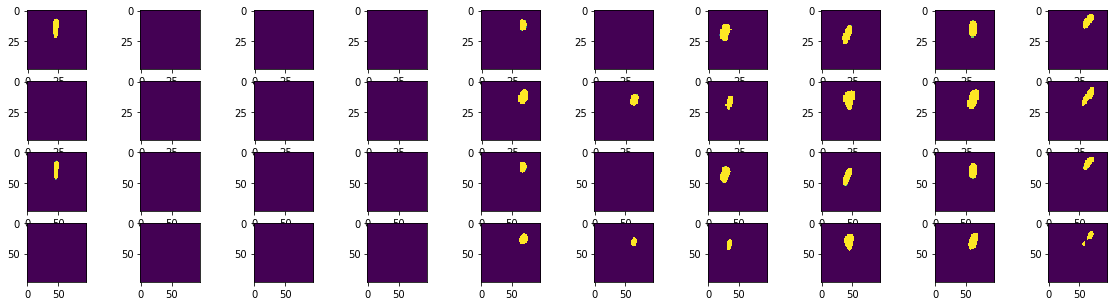

In [23]:
fig, ax = plt.subplots(4,10,figsize=(20,5))
axes = ax.flatten()

idx = np.random.randint(1000,size=(10))
# idx = np.arange(10)
for i in range(10):
    axes[i].imshow(imgs_mask1[idx[i]].reshape(48,48), label="pred1")
    axes[i+10].imshow(t1[idx[i]].reshape(48,48), label="actual1")
    axes[i+20].imshow(imgs_mask[idx[i]].reshape(96,96),label="pred")
    axes[i+30].imshow(t[idx[i]].reshape(96,96),label="actual")
    

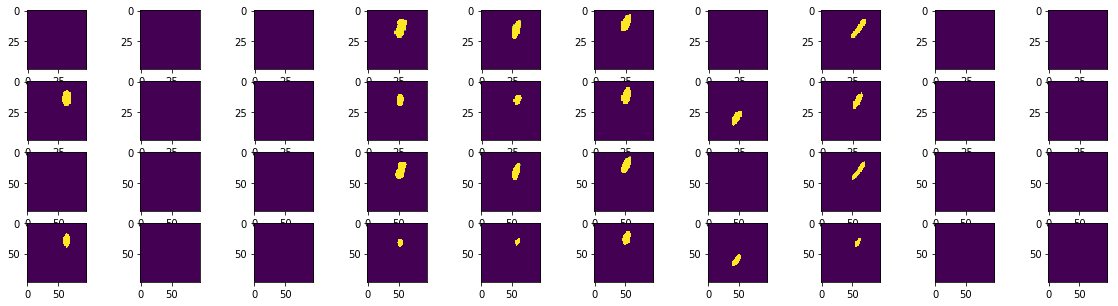

In [18]:
fig, ax = plt.subplots(4,10,figsize=(20,5))
axes = ax.flatten()

idx = np.random.randint(100,size=(10))
# idx = np.arange(10)
for i in range(10):
    axes[i].imshow(imgs_mask1[idx[i]].reshape(48,48), label="pred1")
    axes[i+10].imshow(t1[idx[i]].reshape(48,48), label="actual1")
    axes[i+20].imshow(imgs_mask[idx[i]].reshape(96,96),label="pred")
    axes[i+30].imshow(t[idx[i]].reshape(96,96),label="actual")
    

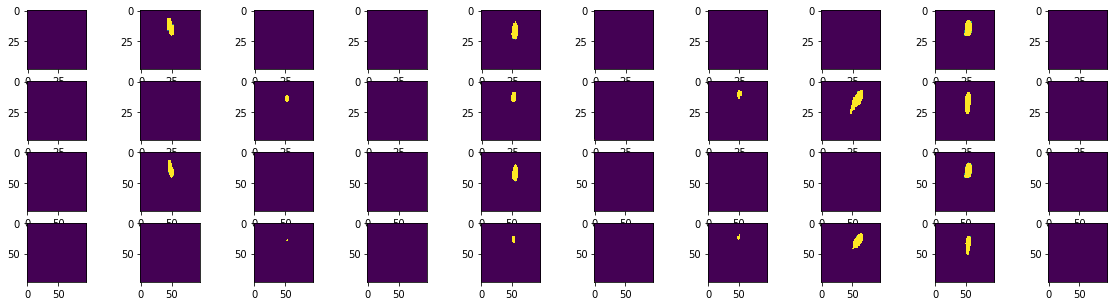

In [25]:
fig, ax = plt.subplots(4,10,figsize=(20,5))
axes = ax.flatten()

idx = np.random.randint(1000,size=(10))
# idx = np.arange(10)
for i in range(10):
    axes[i].imshow(imgs_mask1[idx[i]].reshape(48,48), label="pred1")
    axes[i+10].imshow(t1[idx[i]].reshape(48,48), label="actual1")
    axes[i+20].imshow(imgs_mask[idx[i]].reshape(96,96),label="pred")
    axes[i+30].imshow(t[idx[i]].reshape(96,96),label="actual")
    

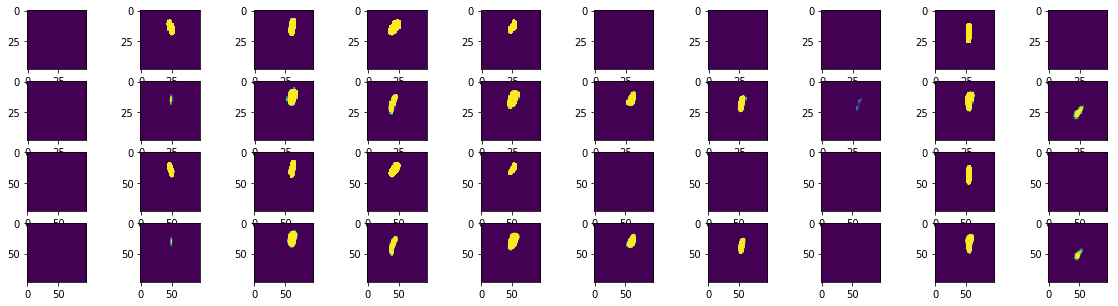

In [37]:

fig, ax = plt.subplots(4,10,figsize=(20,5))
axes = ax.flatten()

for i in range(10):
    axes[i].imshow(imgs_mask1[i].reshape(48,48), label="pred1")
    axes[i+10].imshow(t1[i].reshape(48,48), label="actual1")
    axes[i+20].imshow(imgs_mask[i].reshape(96,96),label="pred")
    axes[i+30].imshow(t[i].reshape(96,96),label="actual")
    

In [40]:
import time

for i in range(10):
    print(i)
    if i%5 == 0:
        time.sleep(5)

0
1
2
3
4
5
6
7
8
9


In [ ]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask, imgs_mask1 = load_train_data()
    imgs_train  = imgs_train.reshape(-1,96,96,1)
    imgs_mask, imgs_mask1 = imgs_mask.reshape(-1,96,96,1), imgs_mask1.reshape(-1,48,48,1) 

    print("imgs_train: {}, imgs_mask1: {}, imgs_mask: {}".format(imgs_train.shape, 
        imgs_mask1.shape, imgs_mask.shape))
    # imgs_train = preprocess(imgs_train)
    # imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask = imgs_mask.astype('float32')
    imgs_mask /= 255.  # scale masks to [0, 1]
    imgs_mask1 = imgs_mask1.astype('float32')
    imgs_mask1 /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, [imgs_mask1, imgs_mask], batch_size=32, 
                nb_epoch=20*5, verbose=2, shuffle=True,
                validation_split=0.2,
                callbacks=[model_checkpoint])

    print("training done")
    print('-'*30)
    # print('Loading and preprocessing test data...')
    # print('-'*30)
    # imgs_test, imgs_id_test = load_test_data()
    # imgs_test = preprocess(imgs_test)

    # imgs_test = imgs_test.astype('float32')
    # imgs_test -= mean
    # imgs_test /= std

    # print('-'*30)
    # print('Loading saved weights...')
    # print('-'*30)
    # model.load_weights('weights.h5')

    # print('-'*30)
    # print('Predicting masks on test data...')
    # print('-'*30)
    # imgs_mask_test = model.predict(imgs_test, verbose=1)
    # np.save('imgs_mask_test.npy', imgs_mask_test)

    # print('-' * 30)
    # print('Saving predicted masks to files...')
    # print('-' * 30)
    # pred_dir = 'preds'
    # if not os.path.exists(pred_dir):
    #     os.mkdir(pred_dir)
    # for image, image_id in zip(imgs_mask_test, imgs_id_test):
    #     image = (image[:, :, 0] * 255.).astype(np.uint8)
    #     imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)

if __name__ == '__main__':
    train_and_predict()


